- Uid: u1428543
- Date: Jun 2, 2023
- Class: CS6017

# Homework 3 - Scraping and Regression

## Part 1 - Data Acquisition


In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

hackernews_file = 'hackernews_stories.csv'

def convert_to_hours(age):
    if 'hour' in age:
        return int(age.split()[0])
    elif 'minute' in age:
        return int(age.split()[0]) / 60
    elif 'day' in age:
        return int(age.split()[0]) * 24
    else:
        return 0

def scrape_hackernews_stories():
    stories_data = []

    for page in range(1, 6): 
        url = f"https://news.ycombinator.com/news?p={page}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        story_rows = soup.select(".athing")

        for row in story_rows:
            rank = row.find(class_="rank").text.strip(".")
            title = row.find(class_="titleline").text

            next_row = row.find_next_sibling("tr")
           
            if next_row:
                original_age_string = next_row.find(class_="age").text.replace(
                    " ago", "").strip()
                age = convert_to_hours(original_age_string)
                points = next_row.find(class_="score").text.split()[
                    0] if next_row.find(class_="score") else "0"
                comments = next_row.find("a", href=lambda href: href and "item?id" in href).text.split()[
                    0] if next_row.find("a", href=lambda href: href and "item?id" in href) else "0"
            else:
                age = "N/A"
                points = "N/A"
                comments = "N/A"


            stories_data.append({
                "Rank": rank,
                "Title": title,
                "Age(hours)": age,
                "Points": points,
                "Comments": comments
            })

    df = pd.DataFrame(stories_data)
    df.to_csv(hackernews_file, index=False)
    print(f"Scraping completed. Data saved to {hackernews_file}.")

# uncomment the next line to get new data
# scrape_hackernews_stories()


## Part 2 - Regression

### Model 1: Multiple linear regression using Title length, Age, Points, Comments to predict the rank

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df = pd.read_csv(hackernews_file)  

df['Title Length'] = df['Title'].apply(len)

X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]
y = df['Rank']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_pred = regression.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R^2 score:", r2)

coefficients = pd.DataFrame(
    regression.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients)


R^2 score: 0.36055454131251286
Coefficients:
              Coefficient
Title Length     0.035818
Age(hours)       2.952500
Points          -0.126161
Comments        -0.459907


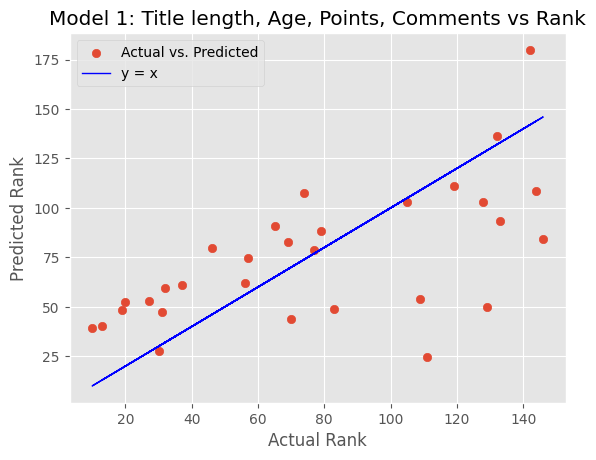

In [16]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_regression_results(y_test, y_pred, plot_title):
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color='blue', linewidth=1)
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(plot_title)
    plt.legend(['Actual vs. Predicted', 'y = x'], loc='upper left')
    plt.show()


plot_regression_results(
    y_test, y_pred, 'Model 1: Title length, Age, Points, Comments vs Rank')


### Model 2: Multiple linear regression using Age, Comments to predict the rank

In [17]:

X = df[['Age(hours)', 'Comments']]
y = df['Rank']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_pred = regression.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R^2 score:", r2)

coefficients = pd.DataFrame(
    regression.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients)


R^2 score: 0.3139686035189474
Coefficients:
            Coefficient
Age(hours)     2.003944
Comments      -0.292706


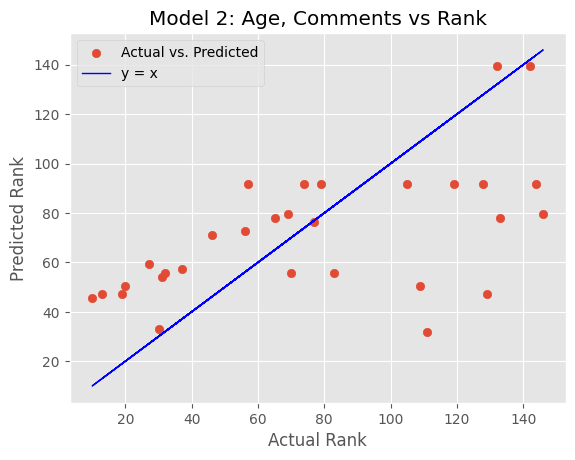

In [18]:
plot_regression_results(
    y_test, y_pred, 'Model 2: Age, Comments vs Rank')


### Model 3: Multiple linear regression using Age, Points and Comments to predict the rank

In [19]:

X = df[['Age(hours)', 'Points', 'Comments']]
y = df['Rank']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_pred = regression.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("R^2 score:", r2)

coefficients = pd.DataFrame(
    regression.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients)


R^2 score: 0.3900063086521509
Coefficients:
            Coefficient
Age(hours)     2.857522
Points        -0.123643
Comments      -0.508076


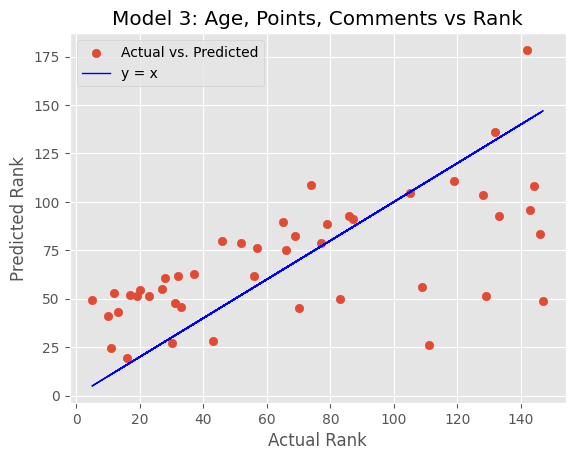

In [20]:
plot_regression_results(y_test, y_pred, 'Model 3: Age, Points, Comments vs Rank')


### Which model is the most useful?

Model 3 ( R^2 = 0.390 ) > Model 1 ( R^2 = 0.361 ) > Model 2 ( R^2 = 0.314 )

Based on the R^2 scores and coefficients, Model 3 appears to be the most useful among the three models. It has the highest R^2 score, indicating a better fit to the data, and all the coefficients have the expected signs, aligning with our intuition. Model 1 also performs relatively well but has a slightly lower R^2 score. Model 2 has the lowest R^2 score and lacks a coefficient for the Points variable, which may limit its usefulness.

### Are there linear relationships between any of the variables? 



              Title Length  Age(hours)    Points  Comments
Title Length      1.000000   -0.123807 -0.065723  0.005254
Age(hours)       -0.123807    1.000000  0.599206 -0.227599
Points           -0.065723    0.599206  1.000000 -0.220949
Comments          0.005254   -0.227599 -0.220949  1.000000


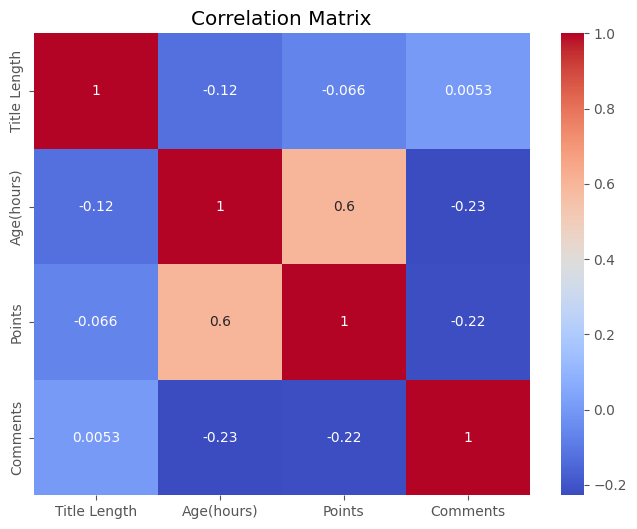

In [22]:
import seaborn as sns

X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]

correlation_matrix = X.corr()

print(correlation_matrix)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Based on the correlation matrix, we can identify the moderate linear relationships between the variables:

1. Age and Points: There is a moderate positive linear relationship between the age of the story in hours and the number of points (0.599206). As the age increases, the points tend to be higher.

2. Age and Comments: There is a moderate negative linear relationship between the age of the story in hours and the number of comments (-0.227599). As the age increases, the number of comments tends to decrease.

3. Points and Comments: There is a moderate negative linear relationship between the number of points and the number of comments (-0.220949). As the number of points increases, the number of comments tends to decrease.

Therefore, based on these moderate linear relationships, we can conclude that there are linear dependencies between the age of a story and both the number of points and the number of comments it receives on Hacker News. Additionally, there is a linear relationship between the number of points and the number of comments.

## Part 3 - Classification

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

first_page_threshold_rank = 30

df['Front Page'] = np.where(df['Rank'] <= first_page_threshold_rank, 1, 0)

X = df[['Title Length', 'Age(hours)', 'Points', 'Comments']]
y = df['Front Page']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)


Accuracy: 0.8
Confusion Matrix:
[[20  4]
 [ 2  4]]


Based on the results:

The accuracy score is 0.8, which indicates that the logistic regression model correctly predicted the front page status (whether an article will be on the front page or not) for 80% of the test instances. Based on these results, the model has a relatively high accuracy.

In [2]:
import numpy as np

x1 = np.linspace(min(X_test['Title Length']), max(X_test['Title Length']), 100)
x2 = np.linspace(min(X_test['Age(hours)']), max(X_test['Age(hours)']), 100)
X1, X2 = np.meshgrid(x1, x2)


X_grid = np.array([X1.flatten(), X2.flatten(),
                  np.zeros(10000), np.zeros(10000)]).T
y_grid = logreg.predict(X_grid)


y_grid = y_grid.reshape(X1.shape)


plt.scatter(X_test['Title Length'], X_test['Age(hours)'],
            c=y_test, cmap='RdYlBu', edgecolors='k', label='Actual')

plt.contourf(X1, X2, y_grid, alpha=0.5, cmap='RdYlBu', levels=1)

plt.xlabel('Title Length')
plt.ylabel('Age (hours)')
plt.title('Logistic Regression Decision Boundary')

plt.colorbar(label='Predicted')

plt.legend()

plt.show()


NameError: name 'X_test' is not defined